# Test code for Spin Ice Project

In [1]:
###Imports###
%matplotlib notebook

import numpy as np
import mpmath as mp
mp.dps = 15; mp.pretty = True
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import random

In [2]:
#####SINGLE MONOPOLE MODEL####

##function to compute physical values of single monopole spin ice system
#
def single_monopole(start_mu, start_T, T_step, T_max, tol, limit, switch, arbit_n):

    '''function to compute physical values of single monopole spin ice system
    Inputs:
    start_mu: the magnitude of the initial value of the chemical potential in kelvin
    start_T: the starting temperature in Kelvin
    T_step: iteration step of temperature
    T_max: the maximum temperature the function will run to
    tol: the convergence tolerance of the iterated chemical potentials
    limit: how many iterations on chemical potential the function will perform without achieving convergence
    switch: boolean, determines if for the first loop init_mu (False) is used
    or an arbitrary n value is used instead (True)
    arbit_n: an arbitrary value of n to be used for the first loop if enabled by the boolean
    '''
    
    ###constants###
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    TempArray = []
    SpecHeatArray = []
    nArray = []
    muSingleArray = []
    freeEnergyArray= []
    internalEnergyArray = []
    l_DArray = []
    
    while T <= T_max :
        
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi) #Bjerrum length
        i=0 #iteration counter
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            
            if switch == True:
                n = arbit_n
                rho = n/vol_per_site
                #print("rho:", rho)
                l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Debye length
                #print("l_D: ", l_D)
                #print("l_T:", l_T)
            
                deltaDH = k_B * T * ((l_T)/(l_D + a)) #Correction derived from Debye-Hueckel theory
                new_mu = init_mu + deltaDH #Corrected mu
                #print("deltaDH:",deltaDH)
                #print("mu:", new_mu)
                #print(old_mu)
                #print(np.abs(new_mu - old_mu))
                #print("")
                i += 1
                #switch = False

            else:
                #print("new mu:", new_mu)
                old_mu = new_mu #if new and old values not close enough, new replaces old
                #new number of monopoles
                n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu))))
                #print("n:", n)
            
                #calculating new Debye length
                rho = n/vol_per_site
                #print("rho:", rho)
                l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Deby length Calc
                #print("l_D: ", l_D)
                #print("l_T:", l_T)
                
                deltaDH = k_B * T * ((l_T)/(l_D + a))
                new_mu = init_mu + deltaDH
                #print("deltaDH:",deltaDH)
                #print("mu:", new_mu)
                #print(old_mu)
                #print(np.abs(new_mu - old_mu))
                #print("")
                i += 1
                if i==limit & limit != 1:
                    print('Warning: Monopole density did not converge after',limit, 'iterations!')
                    # This stops the function running forever if there is a problem with convergence.
        
        switch = False
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho * mu_0))) + a))) ))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho * mu_0))) + a)))))))), T)
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))/(1 +(1/3 * (4 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))))), T)
        SpecHeatVal = - N_0 * (new_mu * float(differential))
        #print("differential of :", differential)
        #print("Specific Heat Value:", SpecHeatVal)
        
        #freeEnergy = (2 * new_mu * 2 * n) + ((Q*Q)/a)/(1 + a/l_D)
        fTerm3 = k_B*T*((n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)))
        freeEnergy = -(new_mu + ((mu_0 * Q**2)/(4*np.pi*a)))*n + (l_D/a * deltaDH * n) + fTerm3
        
        #internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        muSingleArray= np.append(muSingleArray, new_mu)
        TempArray = np.append(TempArray, T)
        nArray = np.append(nArray,n)
        SpecHeatArray = np.append(SpecHeatArray, SpecHeatVal)
        freeEnergyArray = np.append(freeEnergyArray, freeEnergy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        l_DArray = np.append(l_DArray, l_D)
        T += T_step
        #print("done")
    
    ##numerical calculation of entropy, omega##
    DiffNumerical = np.gradient(nArray, T_step)
    SpecHeatNumerical = - 1/2 * N_0 * (muSingleArray * DiffNumerical)

    DeltaS = cumtrapz((SpecHeatNumerical)/TempArray, TempArray)
    DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (TempArray*EntropyTotalArray)
    print("")
    print("final")
    #print("Temperature values:", TempArray)
    #print("Specific Heat array:", SpecHeatArray)
    return (TempArray, SpecHeatArray, nArray, muSingleArray, freeEnergyArray, internalEnergyArray, l_DArray, SpecHeatNumerical, DeltaS, Omega, EntropyTotalArray)

In [6]:
def free_energy_single(mu, T, n_start, n_step, n_max, vacuum_entropy):
    
    #constants#
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    n = n_start
    
    #array initialisation#
    nArray = []
    OmegaArray = []
    
    #to turn on/off the vacuum entropy
    if vacuum_entropy == True:
        switch = 1
    else:
        switch = 0
    
    while n <= n_max:
        #rho = n/vol_per_site
        #l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Debye length Calc
        
        #internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        #internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #Total internal energy
        internalEnergy = - ((4 * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #per site internal energy in Kelvin
        
        #Entropy = -k_B*N_0*( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)) ) #Total entropy
        Entropy = -( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + (switch*(1-n)*np.log(2/3)) ) #entropy per site w/out k_B
        
        #Omega = internalEnergy - (-mu*k_B * (N_0*n)) - (T*Entropy) #total free energy
        Omega = internalEnergy - (-mu*n) - (T*Entropy) #free energy per site in Kelvin
        
        nArray = np.append(nArray, n)
        OmegaArray = np.append(OmegaArray, Omega)
        
        n+=n_step
        
    return(nArray, OmegaArray)

In [101]:
###finding minimums of omega arrays###
def minimum_finder(nArray, omegaArray):
    minima_ypos = []
    minima_xpos = []
    i = 2
    
    while i < np.size(omegaArray):
        third = omegaArray[i-2]
        second = omegaArray[i-1]
        first = omegaArray[i]
        
        if (second < third) & (second < first):
            minima_ypos = np.append(minima_ypos, second)
            minima_xpos = np.append(minima_xpos, nArray[i-1])
        
        i+=1
    
    return(minima_xpos, minima_ypos)


In [6]:
###4.35 mu values, arbit_n = 0.0000141839###
#TempArray, SpecHeatArray, nArray, muSingleArray, freeEnergyArray, internalEnergyArray, l_DArray, SpecHeatNumerical, DeltaS, Omega, EntropyTotalArray = single_monopole(1.57, 0.1, 0.001, 2, 1e-4, 1000, True, 0.0000141839)

###4.35 mu values, arbit_n = 0.0929362###
#TempArray2, SpecHeatArray2, nArray2, muSingleArray2, freeEnergyArray2, internalEnergyArray2, l_DArray2, SpecHeatNumerical2, DeltaS2, Omega2, EntropyTotalArray2 = single_monopole(1.57, 0.1, 0.001, 2, 1e-4, 1000, True, 0.0929362)


final

final


In [7]:
###0.50 mu, small ###
TempArray1, SpecHeatArray1, nArray1, muSingleArray1, freeEnergyArray1, internalEnergyArray1, l_DArray1, SpecHeatNumerical1, DeltaS1, Omega1, EntropyTotalArray1 = single_monopole(0.50, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

###1.00 mu, small ###
TempArray2, SpecHeatArray2, nArray2, muSingleArray2, freeEnergyArray2, internalEnergyArray2, l_DArray2, SpecHeatNumerical2, DeltaS2, Omega2, EntropyTotalArray2 = single_monopole(1.00, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

###1.15 mu, small ###
TempArray3, SpecHeatArray3, nArray3, muSingleArray3, freeEnergyArray3, internalEnergyArray3, l_DArray3, SpecHeatNumerical3, DeltaS3, Omega3, EntropyTotalArray3 = single_monopole(1.15, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

###1.30 mu, small ###
TempArray4, SpecHeatArray4, nArray4, muSingleArray4, freeEnergyArray4, internalEnergyArray4, l_DArray4, SpecHeatNumerical4, DeltaS4, Omega4, EntropyTotalArray4 = single_monopole(1.30, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

###1.570 mu, transition ###
TempArray5, SpecHeatArray5, nArray5, muSingleArray5, freeEnergyArray5, internalEnergyArray5, l_DArray5, SpecHeatNumerical5, DeltaS5, Omega5, EntropyTotalArray5 = single_monopole(1.57, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

##1.90 mu post-transition###
TempArray6, SpecHeatArray6, nArray6, muSingleArray6, freeEnergyArray6, internalEnergyArray6, l_DArray6, SpecHeatNumerical6, DeltaS6, Omega6, EntropyTotalArray6 = single_monopole(1.90, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

##2.50 mu post-transition###
TempArray7, SpecHeatArray7, nArray7, muSingleArray7, freeEnergyArray7, internalEnergyArray7, l_DArray7, SpecHeatNumerical7, DeltaS7, Omega7, EntropyTotalArray7 = single_monopole(2.50, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)

###4.35 mu, initial mu ###
TempArray8, SpecHeatArray8, nArray8, muSingleArray8, freeEnergyArray8, internalEnergyArray8, l_DArray8, SpecHeatNumerical8, DeltaS8, Omega8, EntropyTotalArray8 = single_monopole(4.35, 0.01, 0.001, 2, 1e-4, 1000, False, 0.0000141839)


final

final

final

final

final

final

final

final


Important temperatures are:

$T=0.1910$ K post transition

$T=0.1505$ K transition

$T=0.1305$ K pre transition

Important chemical potentials are:

$\mu = -4.35$ K large

$\mu = -1.57$ K transition

$\mu = -0.50$ K small

In [7]:
###First halves of Omega datasets###
#1.570 mu
nArray_TempStatic5, OmegaArray_TempStatic5 = free_energy_single(1.570, 0.1505, 10**-8, 10**-8, 10**-4, True)

#4.350 mu
nArray_TempStatic8, OmegaArray_TempStatic8 = free_energy_single(4.350, 0.1505, 10**-8, 10**-8, 10**-4, True)

#0.500 mu
nArray_TempStatic1, OmegaArray_TempStatic1 = free_energy_single(0.500, 0.1505, 10**-8, 10**-8, 10**-4, True)

In [8]:
###Second halves of Omega datasets###
#1.570 mu
nArray_TempStatic5_2, OmegaArray_TempStatic5_2 = free_energy_single(1.570, 0.1505, 10**-4, 10**-4, 10**-0, True)

#4.350 mu
nArray_TempStatic8_2, OmegaArray_TempStatic8_2 = free_energy_single(4.350, 0.1505, 10**-4, 10**-4, 10**-0, True)

#0.500 mu
nArray_TempStatic1_2, OmegaArray_TempStatic1_2 = free_energy_single(0.500, 0.1505, 10**-4, 10**-4, 10**-0, True)

<IPython.core.display.Javascript object>


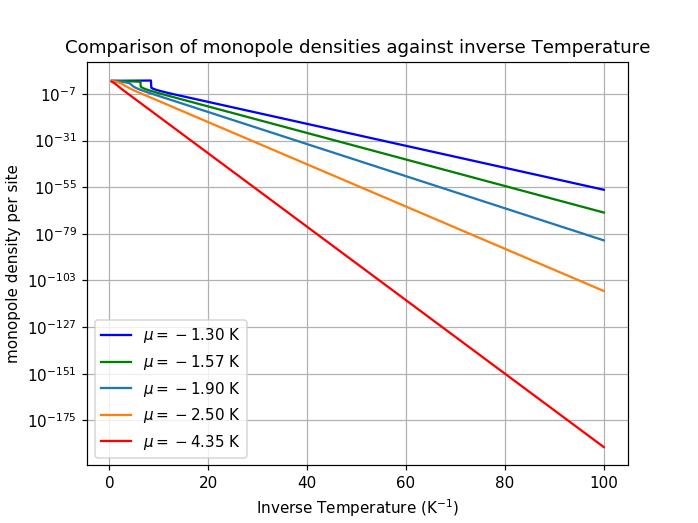

In [8]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

plt.plot(1/TempArray4, nArray4, 'b-', label="$\mu=-1.30$ K")
plt.plot(1/TempArray5, nArray5, 'g-', label="$\mu=-1.57$ K")
plt.plot(1/TempArray6, nArray6, '-', label="$\mu=-1.90$ K")
plt.plot(1/TempArray7, nArray7, '-', label="$\mu=-2.50$ K")
plt.plot(1/TempArray8, nArray8, 'r-', label="$\mu=-4.35$ K")

#plt.plot(TempArray2, nArray2, 'r-', label="$\mu=1.570$, $n_{large}$")
plt.xlabel("Inverse Temperature (K$^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
plt.title("Comparison of monopole densities against inverse Temperature")
plt.legend(loc='lower left')
#plt.savefig('monopole densities against inverse temp comparison.png')

<IPython.core.display.Javascript object>


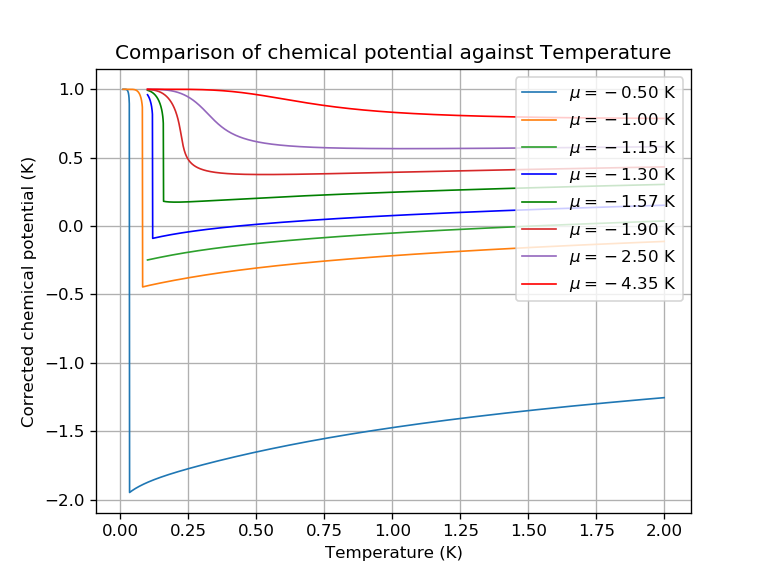

In [86]:
###corrected chemical potential aginst temperature###
graph1 = plt.figure()
plt.grid(True)
#plt.plot(TempArray1, muSingleArray1/((k_B)*-1.57), 'g-', linewidth=1, label="$\mu=-1.57$ K")
#plt.plot(TempArray2, muSingleArray2/((k_B)*-4.35), 'r-', linewidth=1, label="$\mu=-4.35$ K")
#plt.plot(TempArray3, muSingleArray3/((k_B)*-1.30), 'b-', linewidth=1, label="$\mu=-1.30$ K")
#plt.plot(TempArray4, muSingleArray4/((k_B)*-1.90), '-', linewidth=1, label="$\mu=-1.90$ K")
#plt.plot(TempArray5, muSingleArray5/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")

plt.plot(TempArray1, muSingleArray1/((k_B)*-0.50), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray2, muSingleArray2/((k_B)*-1.00), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, muSingleArray3/((k_B)*-1.15), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, muSingleArray4/((k_B)*-1.30), 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, muSingleArray5/((k_B)*-1.57), 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, muSingleArray6/((k_B)*-1.90), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, muSingleArray7/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, muSingleArray8/((k_B)*-4.35), 'r-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Corrected chemical potential (K)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Comparison of chemical potential against Temperature")
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


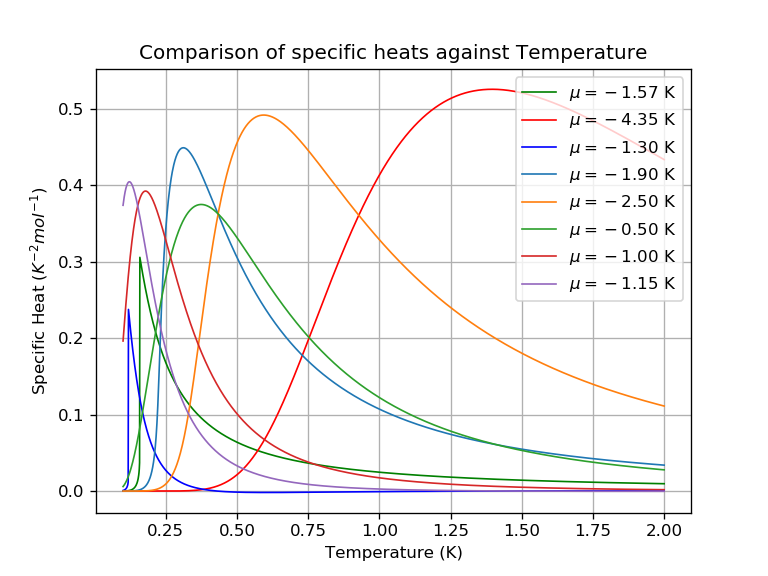

In [72]:
###Specific Heat aginst temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray1, SpecHeatArray1/(k_B*N_0), 'g-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray2, SpecHeatArray2/(k_B*N_0), 'r-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, SpecHeatArray3/(k_B*N_0), 'b-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, SpecHeatArray4/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, SpecHeatArray5/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, SpecHeatArray6/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, SpecHeatArray7/(k_B*N_0), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, SpecHeatArray8/(k_B*N_0), '-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat ($K^{-2} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Comparison of specific heats against Temperature")
plt.legend(loc='upper right')
#plt.savefig('SpecHeatAgainstTemperature1.pdf')

In [73]:
print("mu=-0.50:",TempArray1[np.argmax(SpecHeatArray1)],"K")
print("mu=-1.00:",TempArray2[np.argmax(SpecHeatArray2)],"K")
print("mu=-1.15:",TempArray3[np.argmax(SpecHeatArray3)],"K")
print("mu=-1.30:",TempArray4[np.argmax(SpecHeatArray4)],"K")
print("mu=-1.57:",TempArray5[np.argmax(SpecHeatArray5)],"K")
print("mu=-1.90:",TempArray6[np.argmax(SpecHeatArray6)],"K")
print("mu=-2.50:",TempArray7[np.argmax(SpecHeatArray7)],"K")
print("mu=-4.35:",TempArray8[np.argmax(SpecHeatArray8)],"K")

mu=-0.50: 0.3740000000000002 K
mu=-1.00: 0.17900000000000008 K
mu=-1.15: 0.12200000000000003 K
mu=-1.30: 0.11900000000000002 K
mu=-1.57: 0.15900000000000006 K
mu=-1.90: 0.31200000000000017 K
mu=-2.50: 0.5940000000000004 K
mu=-4.35: 1.395999999999957 K


<IPython.core.display.Javascript object>


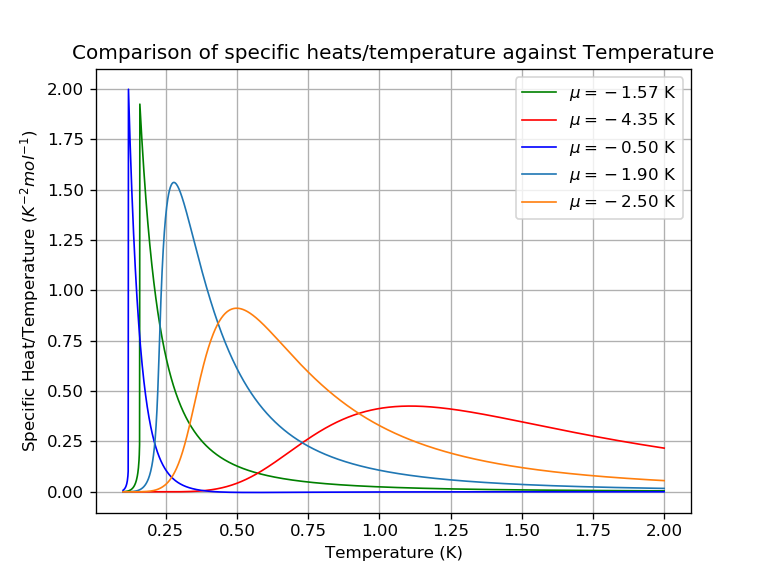

In [56]:
###Specific Heat aginst temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray1, SpecHeatArray1/(k_B*N_0*TempArray1), 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray2, SpecHeatArray2/(k_B*N_0*TempArray2), 'r-', linewidth=1, label="$\mu=-4.35$ K")
plt.plot(TempArray3, SpecHeatArray3/(k_B*N_0*TempArray3), 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray4, SpecHeatArray4/(k_B*N_0*TempArray4), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray5, SpecHeatArray5/(k_B*N_0*TempArray5), '-', linewidth=1, label="$\mu=-2.50$ K")


plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat/Temperature ($K^{-2} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Comparison of specific heats/temperature against Temperature")
plt.legend(loc='upper right')
#plt.savefig('SpecHeatAgainstTemperature1.pdf')

In [1]:
###n against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray6, nArray6, '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray7, nArray7, '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray8, nArray8, '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray3, nArray3, 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray1, nArray1, 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray4, nArray4, '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray5, nArray5, '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray2, nArray2, 'r-', linewidth=1, label="$\mu=-4.35$ K")


plt.xlabel("Temperature (K)")
plt.ylabel("density of monopoles per site")
plt.xscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Comparison of monopole density per site against Temperature")
plt.legend(loc='upper right')

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


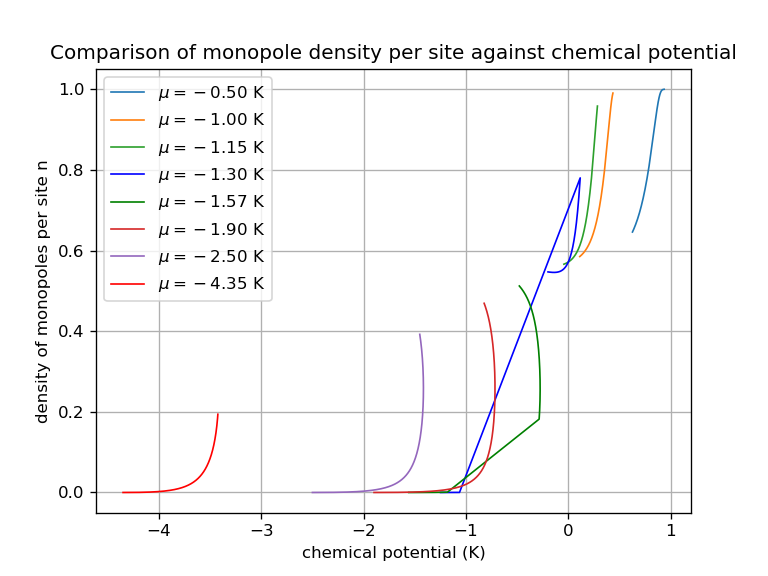

In [81]:
###n against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(muSingleArray6/k_B, nArray6, '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(muSingleArray7/k_B, nArray7, '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(muSingleArray8/k_B, nArray8, '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(muSingleArray3/k_B, nArray3, 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(muSingleArray1/k_B, nArray1, 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(muSingleArray4/k_B, nArray4, '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(muSingleArray5/k_B, nArray5, '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(muSingleArray2/k_B, nArray2, 'r-', linewidth=1, label="$\mu=-4.35$ K")


plt.xlabel("chemical potential (K)")
plt.ylabel("density of monopoles per site n")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Comparison of monopole density per site against chemical potential")
plt.legend(loc='upper left')

In [133]:
omegaMinima1 = minimum_finder(nArray_TempStatic1_2, OmegaArray_TempStatic1_2)
print(omegaMinima1)

(array([0.0002, 0.1011]), array([-0.06103524, -0.06220395]))


In [121]:
#checking minimums#
print(nArray_TempStatic1_2[1])
print(OmegaArray_TempStatic1_2[0], OmegaArray_TempStatic1_2[1], OmegaArray_TempStatic1_2[2])

0.0002
-0.061035070716325156 -0.06103524198941372 -0.06103247528496595


In [91]:
print(np.amin(OmegaArray_TempStatic1_2))

-0.062203950912202724


<IPython.core.display.Javascript object>


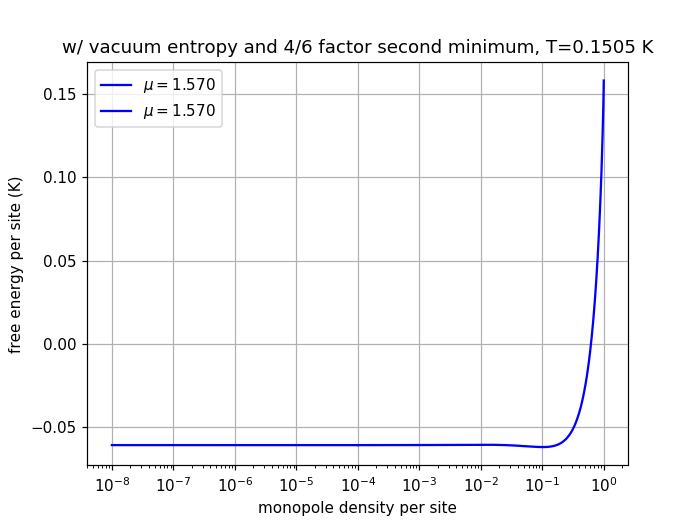

In [23]:
###free energy against equilibrium monopole density per site###
k_B = 1.38064852 * 10**-23 #Boltzmann constant

MonopoleDensityGraph1 = plt.figure()
plt.grid(True)
plt.plot(nArray_TempStatic5, OmegaArray_TempStatic5, 'b-', label="$\mu=1.570$")
plt.plot(nArray_TempStatic5_2, OmegaArray_TempStatic5_2, 'b-', label="$\mu=1.570$")

#plt.plot(nArray_TempStatic8, OmegaArray_TempStatic8, 'r-', label="$\mu=4.350$")
#plt.plot(nArray_TempStatic8_2, OmegaArray_TempStatic8_2, 'r-', label="$\mu=4.350$")

#plt.plot(nArray_TempStatic1, OmegaArray_TempStatic1, 'g-', label="$\mu=0.500$")
#plt.plot(nArray_TempStatic1_2, OmegaArray_TempStatic1_2, 'g-', label="$\mu=0.500$")

plt.xlabel("monopole density per site")
plt.xscale('log')

#plt.xlim(10**-3, 10**-0)
#plt.ylim(-0.0625,-0.05)

##0.7 mu minimum
#plt.xlim(0.9, 1)
#plt.ylim(-0.8, -0.6)

#1.570 mu T-0.1505 first minimum
#plt.ylim(-0.0611, -0.0609)
#plt.xlim(0.00004, 0.00025)

#1.570 mu T=0.1505 second minimum
#plt.xlim(0.03, 0.25)
#plt.ylim(-0.0625,-0.058)

plt.ylabel("free energy per site (K)")
plt.title("w/ vacuum entropy and 4/6 factor second minimum, T=0.1505 K")
plt.legend(loc='upper left')
#plt.savefig('Omega against monopole density second minimum, mu=1.570 T=0.1505 K.png')

In [ ]:
###mu against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray, muSingleArray, 'b-', linewidth=0.5, label="$\mu=1.570$, $n_{small}$")
plt.plot(TempArray2, muSingleArray2, 'r-', linewidth=0.5, label="$\mu=1.570$, $n_{large}$")
plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat (J$K^{-1} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
plt.ylim(-0.40*10**-23, -0.375*10**-23)
plt.title("Comparison of mu tilde against Temperature")
plt.legend(loc='upper right')
plt.savefig('SpecHeatAgainstTemperature1.pdf')

In [8]:
###Single + Double monopole model###
def double_monopole(start_mu, start_mu_2, start_T, T_step, T_max, tol, limit):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    TempArray_double = []
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    while T <= T_max :
        
        i = 0
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        old_mu_2 = 0
        new_mu_2 = -start_mu_2 * k_B
        init_mu_2 = -start_mu_2 * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi)
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            n_2 = (1/3 * np.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new Debye length
            rho = n/vol_per_site
            rho_2 = n_2/vol_per_site
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))/(1 +(1/3 * (4 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))))), T)
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*np.log(n/2) + (n_2*np.log(2*n_2) + ((1-n-n_2)*np.log(1-n-n_2)) + ((1-n-n_2)*np.log(2/3)) ) ) )
        #Entropy_corrected = Entropy - (8.314 * 1/2*np.log(3/2))
        
        internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        TempArray_double = np.append(TempArray_double, T)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        T += T_step
        #print("done")
        
    ##numerical calculation of entropy, omega##
    DiffNumerical = np.gradient(nArray, T_step)
    DiffNumerical_2 = np.gradient(n_2Array, T_step)
    SpecHeatNumerical = - 1/2 * N_0 * (muDoubleArray * DiffNumerical + mu2DoubleArray * DiffNumerical_2)

    DeltaS = cumtrapz((SpecHeatNumerical)/TempArray_double, TempArray_double)
    DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyTotalArray)
        
    print("")
    print("final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, SpecHeatNumerical, EntropyTotalArray, Omega)

In [21]:
###1.57 mu values, double monopole###
TempArray_double, SpecHeatArray_double, EntropyArray_double, muDoubleArray, mu2DoubleArray, nArray_double, n_2Array_double, SpecHeatNumerical_double, EntropyTotalArray_double, Omega_double = double_monopole(1.57, 4*1.57, 0.1, 0.001, 10, 1e-4, 1000)



final


<IPython.core.display.Javascript object>


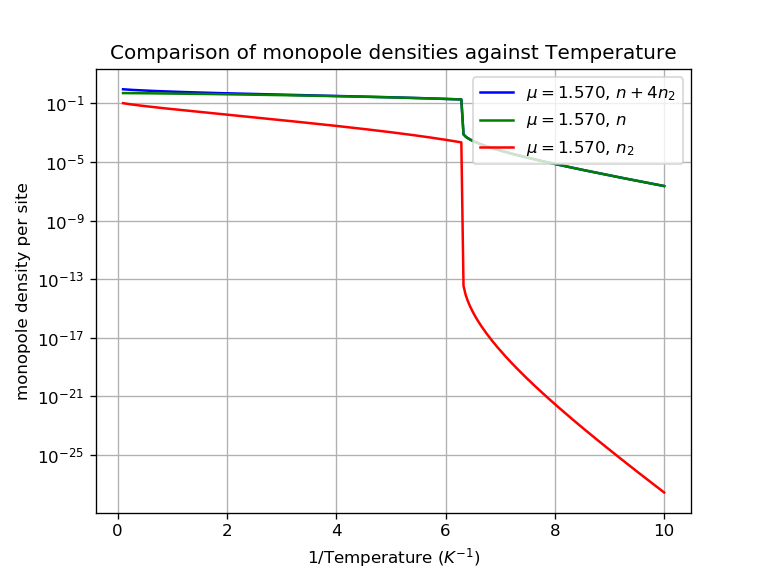

In [24]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(1/TempArray_double, nArray_double + 4*n_2Array_double, 'b-', label="$\mu=1.570$, $n+4n_2$")
plt.plot(1/TempArray_double, nArray_double, 'g-', label="$\mu=1.570$, $n$")
plt.plot(1/TempArray_double, n_2Array_double, 'r-', label="$\mu=1.570$, $n_2$")
plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.title("Comparison of monopole densities against Temperature")
plt.legend(loc='upper right')